In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
%matplotlib inline

'''%matplotlib inline is used to make sure that the image from matlplotlib is opened in 
the same notebook and not a different pop-up. The "%" symbol is used for magic commands which are there for changing behavior of notebook'''


'%matplotlib inline is used to make sure that the image from matlplotlib is opened in \nthe same notebook and not a different pop-up. The "%" symbol is used for magic commands which are there for changing behavior of notebook'

In [ ]:
## Setting up Hyperparameters

batch_size = 128
lr = 1e-5

## Model Constraints

image_size = 28*28
num_classes = 10


Dataset Download and Preprocessing


100%|██████████| 9912422/9912422 [00:00<00:00, 90101491.11it/s]


Extracting /root/MNIST/raw/train-images-idx3-ubyte.gz to /root/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39599769.15it/s]

Extracting /root/MNIST/raw/train-labels-idx1-ubyte.gz to /root/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24570703.69it/s]


Extracting /root/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7271194.19it/s]


Extracting /root/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/MNIST/raw

length of training dataset is 50000
length of validation dataset is 10000
length of testing dataset is 10000
The label of the image is 5


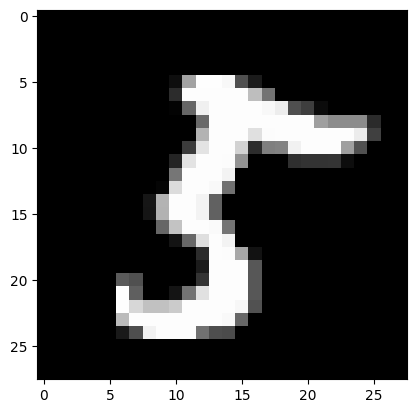

In [ ]:
# Download training and testing datasets 
'''The dataset is downloaded in the format of (Image, Label) where Image is the object of PIL.Image.Image class 
    while Label is the number represented in the MNIST Image, hence we use ToTensor() transform to convert them to tensors'''

train_ds = MNIST('/root', download = True, transform = transforms.ToTensor())
test_ds = MNIST('/root', train = False, transform = transforms.ToTensor())

# Train Validation split using random_split
train_ds, val_ds = random_split(train_ds, [50000, 10000])

print(f"length of training dataset is {len(train_ds)}")
print(f"length of validation dataset is {len(val_ds)}")
print(f"length of testing dataset is {len(test_ds)}")

# Define DataLoaders for creating batches of data

train_dataloader = DataLoader(train_ds, batch_size, shuffle = True)
val_dataloader   = DataLoader(val_ds, batch_size, shuffle = True )
test_dataloader  = DataLoader(test_ds, batch_size, shuffle = True) 

image_sample, label_sample = train_ds[0]
plt.imshow(image_sample[0,:,:], cmap = "gray")
print(f"The label of the image is {label_sample}")

Building Model

In [ ]:
class MNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(image_size, num_classes) # imagesize and num_classes defined at the start
  
  def forward(self, images):
    images = images.reshape(-1, 784) # Convert from tensor of size 128x1x28x28 into a matrix of size 128x784 ("-1" in the reshape function is used for stating that one size should be 784, the other dimension can be adjusted accordingly).
    images = self.linear(images)
    return images

  def training_step(self, batch):
    images, labels = batch
    preds = self(images)
    loss = F.cross_entropy(preds, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    preds = self(images)
    loss = F.cross_entropy(preds, labels)
    acc = accuracy(preds, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc.detach()} # .detach() is used to detach a tensor from computational graph, it'll return a new tensor which doesn't require a gradient 

  def validation_epoch_end(self, epoch_results):
    batch_losses = [x['val_loss'] for x in epoch_results]
    epoch_losses = torch.stack(batch_losses).mean()  
    batch_acc = [x['val_acc'] for x in epoch_results]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_losses.item(), 'val_acc': epoch_acc.item()} 


  def epoch_end(self, epoch_num, results):
    print("Epoch [{}], val_loss: {:.4f}, val_accuracy : {:.4f} ".format(epoch_num, results['val_loss'], results['val_acc']))


In [ ]:
# Creating Model Object
model = MNIST()

Training the model

In [ ]:
# Function for training the model

def fit(epochs, lr, model, train_dataloader, val_dataloader, opt_fn = torch.optim.SGD ):
  history = []
  opt = opt_fn(model.parameters(), lr)

  for epoch in range(epochs):

    # Training Loop

    for batch in train_dataloader:
      loss = model.training_step(batch)
      loss.backward()
      opt.step()
      opt.zero_grad()

    # Validation step

    result = evaluate(model, val_dataloader)
    model.epoch_end(epoch, result)
    history.append(result)

  return history

# Function doing the evaluation process
def evaluate(model, val_dataloader):
  preds = [model.validation_step(batch) for batch in val_dataloader]
  return model.validation_epoch_end(preds)

# Function calculating the accuracy
def accuracy(results, labels):
  value, preds = torch.max(results, dim = 1 )
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))


In [ ]:
# Initial Loss and Accuracy before training
evaluate(model, val_dataloader)

{'val_loss': 2.325991153717041, 'val_acc': 0.05419303849339485}

In [ ]:
# Train the model
history = fit(10, 1e-3, model, train_dataloader, val_dataloader )

Epoch [0], val_loss: 1.9467, val_accuracy : 0.6124 
Epoch [1], val_loss: 1.6769, val_accuracy : 0.7170 
Epoch [2], val_loss: 1.4763, val_accuracy : 0.7542 
Epoch [3], val_loss: 1.3251, val_accuracy : 0.7763 
Epoch [4], val_loss: 1.2089, val_accuracy : 0.7914 
Epoch [5], val_loss: 1.1189, val_accuracy : 0.8019 
Epoch [6], val_loss: 1.0405, val_accuracy : 0.8140 
Epoch [7], val_loss: 0.9847, val_accuracy : 0.8189 
Epoch [8], val_loss: 0.9308, val_accuracy : 0.8254 
Epoch [9], val_loss: 0.8936, val_accuracy : 0.8269 


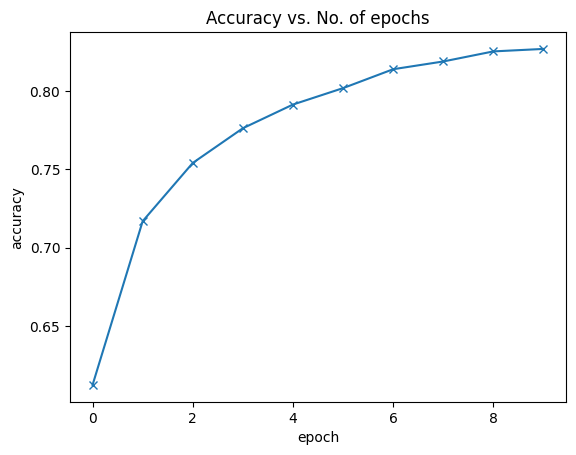

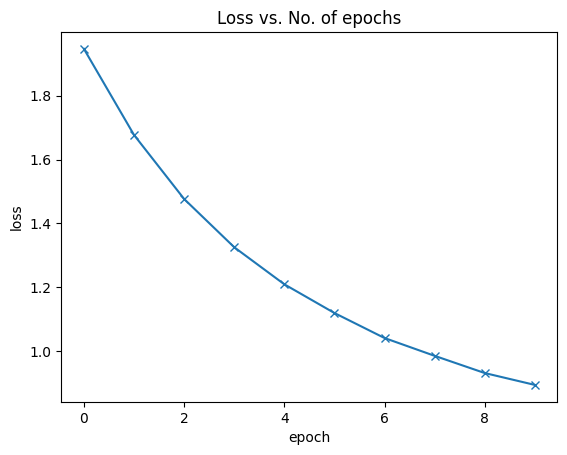

In [ ]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

plt.show()

losses = [r['val_loss'] for r in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [ ]:
# Evaluating on the test dataset

test_results = evaluate(model, test_dataloader)
print(test_results)

{'val_loss': 0.8683179020881653, 'val_acc': 0.8395965099334717}


Predicting Labels on the trained Model

Ground Truth Label: 7, Predicted Label: 7


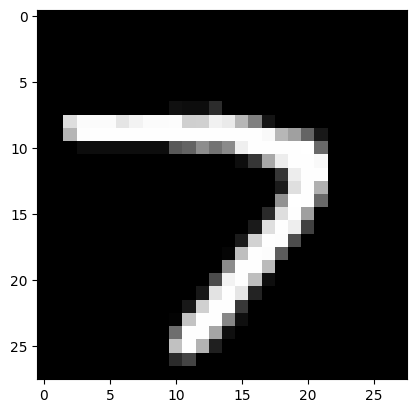

Ground Truth Label: 4, Predicted Label: 4


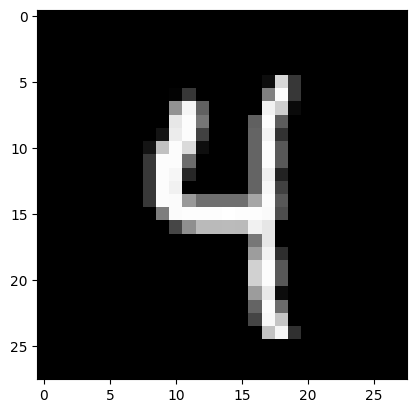

Ground Truth Label: 1, Predicted Label: 1


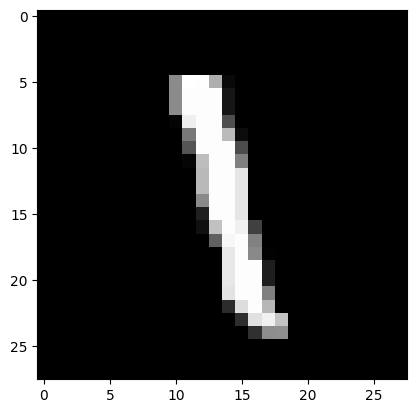

In [ ]:
def predict_label(image, model):
  image = image.unsqueeze(0) # This will return a new tensor with a dimension added at the 0th position, i.e. shape changed from 1x28x28 to 1x1x28x28
  labels = model(image)
  _, pred_label = torch.max(labels, dim = 1)
  return pred_label[0].item()


img, label = test_ds[70]
plt.imshow(img[0,:,:], cmap = 'gray')
print("Ground Truth Label: {}, Predicted Label: {}".format(label, predict_label(img, model)))
plt.show()

img, label = test_ds[170]
plt.imshow(img[0,:,:], cmap = 'gray')
print("Ground Truth Label: {}, Predicted Label: {}".format(label, predict_label(img, model)))
plt.show()

img, label = test_ds[700]
plt.imshow(img[0,:,:], cmap = 'gray')
print("Ground Truth Label: {}, Predicted Label: {}".format(label, predict_label(img, model)))


Saving Model Parameters

In [ ]:
torch.save(model.state_dict(), 'mnist.pth') # Saves a serialized object (containg model parameters and weights) on disk. It uses Python's pickle library for storing.